# Jet Clustering

This workflow is for use with the jet samples, that contain both `ClusterTree` and `EventTree` (provided by the `MLTree` utility). This **cannot** handle data where the `EventTree` does not exist, because that contains info on piecing the clusters together into events*, and the baseline jet clustering.

\* This pieceing together can be accomplished in workflows like `EventReconstructionPion.ipynb` but it's rather complex.

### Setup

First, let's import a bunch of packages we know we'll need right off-the-bat.

- `numpy` for computational stuff, and `numba` to be able to speed it up in some places if needed.
- `ROOT` for file I/O, 4-vector maths and plotting, and `uproot` for quick Pythonic file reading (but not writing).
- A few other "standard" libraries like `sys`, `os`, `glob`, `uuid`, `pathlib` and `subprocess`.
- Our local `util` library, where we have various functions for data preparation, graphics stuff and some jet clustering functionality.

Our jet clustering will be using the Python interface for `fastjet`. This is installed by our setup script in `/LCStudies/setup/fastjet`, and will be accessed within `util.jet_util`.

In [ ]:
# Flag for skipping file preparation. Can turn this on if you have already made the local copy of data files *and* computed
# the network score branches -- which is a time-intensive step. Skipping will give a useful speedup when working on just clustering
# or making plots, but this will crash if you haven't run the data copy / network score steps once.
skip_scores = True

# Flag for skipping calculation of topo-cluster minimum dR. This is a bit time-intensive.
skip_dR = True

# Debug: Uses only one input file, which will speed things up.
debug = False

In [2]:
# Imports - generic stuff
import numpy as np
import pandas as pd
import ROOT as rt
import uproot as ur # uproot for accessing ROOT files quickly (and in a Pythonic way)
import sys, os, glob, uuid # glob for searching for files, uuid for random strings to name ROOT objects and avoid collisions
import subprocess as sub
from numba import jit
from pathlib import Path
from IPython.utils import io # For suppressing some print statements from functions.

path_prefix = os.getcwd() + '/../'
if(path_prefix not in sys.path): sys.path.append(path_prefix)
from util import ml_util as mu # for passing calo images to regression networks
from util import qol_util as qu # for progress bar
from util import jet_util as ju

Welcome to JupyROOT 6.22/02


In [3]:
# To display our plots, let's get a dark style that will look nice in presentations (and JupyterLab in dark mode).
dark_style = qu.PlotStyle('dark')
light_style = qu.PlotStyle('light')
plot_style = dark_style
plot_style.SetStyle() # sets style for plots - still need to adjust legends, paves

Now we import `tensorflow` (and some of its `keras` stuff), as well as some stuff from `sklearn` for neural network I/O scaling.

In [4]:
# Imports and setup for TensorFlow and Keras.
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable some of the tensorflow info printouts, only display errors
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

ngpu = 1
gpu_list = ["/gpu:"+str(i) for i in range(ngpu)]
strategy = tf.distribute.MirroredStrategy(devices=gpu_list)
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

# Dictionary for storing all our neural network models that will be evaluated
network_models = {}

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [5]:
# setup paths

# select our source for training -- options are 'pion' (default) and 'jet'
source = 'pion'

data_dir = path_prefix + 'data/jet'
training_data_dir = path_prefix + 'data/pion' # TODO: deal with situation where source is jet
classification_dir = path_prefix + 'classifier/Models/' + source
regression_dir = path_prefix + 'regression/Models/' + source
fj_dir = path_prefix + '/setup/fastjet/fastjet-install/lib/python3.8/site-packages'
plot_dir = path_prefix + 'jets/Plots'

In [6]:
# Make the Plot directory if it does not exist yet
if(not os.path.exists(plot_dir)): os.makedirs(plot_dir)

In [7]:
# ----- Calorimeter meta-data -----
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
nlayers = len(layers)
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]
assert(len(len_phi) == nlayers)
assert(len(len_eta) == nlayers)
meta_data = {
    layers[i]:{
        'cell_size':(cell_size_eta[i],cell_size_phi[i]),
        'dimensions':(len_eta[i],len_phi[i])
    }
    for i in range(nlayers)
}

In [8]:
# flat classifiers
print('Loading flat classification models... ')
flat_model_files = glob.glob(classification_dir + '/flat/' + '*.h5')
flat_model_files.sort()
flat_model_names = []
for model in flat_model_files:
    model_name = model.split('model_')[-1].split('_flat')[0]
    print('\tLoading ' + model_name + '... ',end='')
    flat_model_names.append(model_name)
    network_models[model_name] = tf.keras.models.load_model(model)
    print('Done.')

# combo classifier
print('Loading simple combo classification model... ',end='')
combo_model_file = classification_dir + '/simple/' + 'model_simple_do20.h5'
network_models['combo'] = tf.keras.models.load_model(combo_model_file)
print('Done.')

# energy regression networks
print('Loading charged-pion energy regression model... ',end='')
charged_energy_model_file = regression_dir + '/' + 'all_charged.h5'
network_models['e_charged'] = tf.keras.models.load_model(charged_energy_model_file)
print('Done.')

print('Loading neutral-pion energy regression model... ',end='')
neutral_energy_model_file = regression_dir + '/' + 'all_neutral.h5'
network_models['e_neutral'] = tf.keras.models.load_model(neutral_energy_model_file)
print('Done.')

Loading flat classification models... 
	Loading EMB1... Done.
	Loading EMB2... Done.
	Loading EMB3... Done.
	Loading TileBar0... Done.
	Loading TileBar1... Done.
	Loading TileBar2... Done.
Loading simple combo classification model... Done.
Loading charged-pion energy regression model... Done.
Loading neutral-pion energy regression model... Done.


Now we make a "local" copy of the jet data. We will only copy over certain branches, and we will skip any files that don't contain an `eventTree` in them.

In [9]:
# our "local" data dir, where we create modified data files
jet_data_dir = path_prefix + 'jets/data'
Path(jet_data_dir).mkdir(parents=True, exist_ok=True)

if(skip_scores):
    data_filenames = glob.glob(jet_data_dir + '/*.root')
    
    # debugging - take only one file, for speed
    if(debug): data_filenames = [data_filenames[0]]
    
else:
    data_filenames = glob.glob(data_dir + '/' + '*.root')

    # debugging - lets us use a single file to speed stuff up a lot.
    if(debug): data_filenames = [data_dir + '/' + 'user.angerami.21685345.OutputStream._000062.root']

    # Get the original data.
    files = {name:rt.TFile(name,'READ') for name in data_filenames}

    # Some data files might be missing an EventTree.
    # For now, we will skip these because our methods count on an existing EventTree.
    delete_keys = []
    for key, val in files.items():
        file_keys = [x.GetName() for x in val.GetListOfKeys()]
        if('ClusterTree' not in file_keys or 'EventTree' not in file_keys):
            delete_keys.append(key)

    for key in delete_keys: 
        print('Ignoring file:',key,'(no EventTree/ClusterTree found).')
        del files[key]

    # now we make a local copy of the files in the jet_data_dir, keeping only certain branches
    active_branches = {}
    active_branches['cluster'] = [
        'runNumber',
        'eventNumber',
        'truthE',
        'truthPt',
        'truthEta',
        'truthPhi',
        'clusterIndex',
        'nCluster',
        'clusterE',
        'clusterECalib',
        'clusterPt',
        'clusterEta',
        'clusterPhi',
        'cluster_nCells',
        'cluster_ENG_CALIB_TOT',
        'EMB1',
        'EMB2',
        'EMB3',
        'TileBar0',
        'TileBar1',
        'TileBar2'
    ]
    active_branches['event'] = [
        'runNumber',
        'eventNumber',
        'lumiBlock',
        'NPV',
        'nTruthPart',
        'clusterCount',
        'nCluster',
        'clusterE',
        'clusterPt',
        'clusterEta',
        'clusterPhi',
        'AntiKt4EMTopoJetsPt',
        'AntiKt4EMTopoJetsEta',
        'AntiKt4EMTopoJetsPhi',
        'AntiKt4EMTopoJetsE',
        'AntiKt4LCTopoJetsPt',
        'AntiKt4LCTopoJetsEta',
        'AntiKt4LCTopoJetsPhi',
        'AntiKt4LCTopoJetsE',
        'AntiKt4TruthJetsPt',
        'AntiKt4TruthJetsEta',
        'AntiKt4TruthJetsPhi',
        'AntiKt4TruthJetsE'
    ]

    tree_names = {'cluster':'ClusterTree','event':'EventTree'}
    data_filenames = []

    l = len(files.keys())
    i = 0
    qu.printProgressBarColor(i, l, prefix='Copying data files:', suffix='Complete', length=50)

    for path, tfile in files.items():
        filename_new = jet_data_dir + '/' + path.split('/')[-1]
        old_trees = {x:tfile.Get(tree_names[x]) for x in tree_names.keys()}
    
        for key, tree in old_trees.items():
            tree.SetBranchStatus('*',0)
            for bname in active_branches[key]: tree.SetBranchStatus(bname,1)
    
        tfile_new = rt.TFile(filename_new,'RECREATE')
        new_trees = {x:old_trees[x].CloneTree() for x in old_trees.keys()}
        tfile_new.Write()
        data_filenames.append(filename_new)
        i += 1
        qu.printProgressBarColor(i, l, prefix='Copying data files:', suffix='Complete', length=50)
        del old_trees
        del new_trees

In [10]:
# Access the files & trees with uproot
tree_names = {'cluster':'ClusterTree','event':'EventTree'}
ur_trees = {file:{tree_key:ur.open(file)[tree_name] for tree_key,tree_name in tree_names.items()} for file in data_filenames}

### Getting network outputs for all clusters

Now we will loop over our data files, and get network scores (classification and predicted energies) for all clusters. Note that the latter involves *scaling* of the data. 

As the phase space of training and testing data may be different, these scalings should match what was used in training and thus will be derived from the *training data*! Note that the code below will need to be changed if we change the training dataset, or any cuts used when initially deriving scalers (e.g. `energy_cut` below).

This isn't the most notebook-esque code, as we're preparing a bunch of inputs *within* the big for loop below (and not saving them or printing them) but it should avoid "out of memory" issues: As we are dealing with a large amount of data, preparing all the data in memory before operating on it will result in very high memory usage.

In [11]:
# Getting our scalers for the energy regression networks. One set for charged pions, one set for neutral pions.

# Get the data from which we derive the scalers.
training_data_filenames = {'pp':training_data_dir+'/piplus.root','pm':training_data_dir+'/piminus.root','p0':training_data_dir+'/pi0.root'}
training_trees = {key:ur.open(val)['ClusterTree'] for key, val in training_data_filenames.items()}
training_branches = ['clusterE', 'clusterEta', 'cluster_ENG_CALIB_TOT']
training_frames = {key:val.pandas.df(training_branches,flatten=False) for key,val in training_trees.items()}

# We applied a lower cut on cluster_ENG_CALIB_TOT, as very low-energy clusters can throw off training.
# We apply the same cut here for consistency, when re-deriving the scalers.
energy_cut = 5.0e-1 # GeV
training_indices = {}
for key in training_frames.keys():
    training_indices[key] = (training_frames[key]['cluster_ENG_CALIB_TOT'] > energy_cut).to_numpy()
    training_frames[key] = training_frames[key][training_indices[key]]

# Combining dataframes. Charged pions will be under 'pp', neutral will be under 'p0'.
training_frames['pp'] = training_frames['pp'].append(training_frames['pm'])
del training_frames['pm']

for key,frame in training_frames.items():
    frame['logE']      = np.log(frame['clusterE']             )
    frame['logECalib'] = np.log(frame['cluster_ENG_CALIB_TOT'])

# Create scalers.
scaler_e   = {key:StandardScaler() for key in training_frames.keys()}
scaler_cal = {key:StandardScaler() for key in training_frames.keys()}
scaler_eta = {key:StandardScaler() for key in training_frames.keys()}

# Fit the scalers.
for key, frame in training_frames.items():
    scaler_e[key].fit(  frame['logE'      ].to_numpy().reshape(-1,1))
    scaler_cal[key].fit(frame['logECalib' ].to_numpy().reshape(-1,1))
    scaler_eta[key].fit(frame['clusterEta'].to_numpy().reshape(-1,1))

# Delete the training data objects, we do not need them any longer.
del training_trees
del training_frames

# Relabel the keys of our scalers, so they make more sense below.
# 'pp' -> 'charged'
# 'p0' -> 'neutral'
for scaler in [scaler_e, scaler_cal, scaler_eta]:
    scaler['charged'] = scaler['pp']
    del scaler['pp']
    scaler['neutral'] = scaler['p0']
    del scaler['p0']

In [12]:
# branch buffer for filling our score trees
    # make our branch buffer
branch_buffer = {
    'charged_likelihood_combo': np.zeros(1,dtype=np.dtype('f8')),
    'clusterE_charged': np.zeros(1,dtype=np.dtype('f8')),
    'clusterE_neutral': np.zeros(1,dtype=np.dtype('f8'))
}

# Name for the tree that will contain network scores.
tree_name = 'ScoreTree'

for dfile, trees in ur_trees.items():
    if(skip_scores): continue # if not recomputing scores, skip this loop
    print ('File:',dfile)
    # Prepare the calo images.
    print('\tPrepping calo images...')
    calo_images = {}
    for layer in layers:
        calo_images[layer] = mu.setupCells(trees['cluster'],layer)
    combined_images = np.concatenate(tuple([calo_images[layer] for layer in layers]), axis=1)

    # Prepare some extra combined input for the energy regressions.
    print('\tPrepping extra inputs...')
    
    e = trees['cluster'].array('clusterE')
    e_calib = trees['cluster'].array('cluster_ENG_CALIB_TOT')
    eta = trees['cluster'].array('clusterEta')
    
    # cleaning for e_calib (empirically needed for e_calib to remove values that are too small)
    epsilon = energy_cut #1.0e-12 # TODO: Should I set this to energy_cut? Would that make sense?
    e_calib = np.where(e_calib < epsilon, epsilon, e_calib)
    
    s_combined,scaler_combined = mu.standardCells(combined_images, layers) # Note: scaler_combined is unused
    
    regression_input = {}
    for key in scaler_e.keys():
        regression_cols = {}
        regression_cols['s_logE'] = scaler_e[key].transform(np.log(e).reshape(-1,1))
        regression_cols['s_eta'] = scaler_eta[key].transform(eta.reshape(-1,1))
        regression_input[key] = np.column_stack((regression_cols['s_logE'], regression_cols['s_eta'],s_combined))

    # now find network scores
    print('\tCalculating network outputs...')
    model_scores = {}
    
    print('\t\tClassification... ', end='')
    # 1) flat networks
    for layer in flat_model_names:
        model = network_models[layer]
        model_scores[layer] = model.predict(calo_images[layer])[:,1] # [:,1] based on Max's code, this is input to combo network. Likelihood of being charged (vs. neutral)
    
    # 2) combo network
    name = 'combo'
    model = network_models[name]
    input_scores = np.column_stack([model_scores[layer] for layer in layers])
    model_scores[name] = model.predict(input_scores)[:,1] # likelihood of being charged pion (versus neutral pion)
    print('Done.')
    
    print('\t\tRegression... ', end='')
    # 3) energy regression networks
    name = 'e_charged'
    model = network_models[name]
    model_scores[name] = np.exp(scaler_cal['charged'].inverse_transform(model.predict(regression_input['charged'])))
    
    name = 'e_neutral'
    model = network_models[name]
    model_scores[name] = np.exp(scaler_cal['neutral'].inverse_transform(model.predict(regression_input['neutral'])))
    print('Done.')
    
    # Now we should save these scores to a new tree.
    f = rt.TFile(dfile, 'UPDATE')
    t = rt.TTree(tree_name, tree_name)
    
    print('Saving network scores to tree ' + tree_name + '... ',end='')    
    # --- Setup the branches using our buffer. This is a rather general/flexible code block. ---
    branches = {}
    for bname, val in branch_buffer.items():
        descriptor = bname
        bshape = val.shape
        if(bshape != (1,)):
            for i in range(len(bshape)):
                descriptor += '[' + str(bshape[i]) + ']'
        descriptor += '/'
        if(val.dtype == np.dtype('i2')): descriptor += 'S'
        elif(val.dtype == np.dtype('i4')): descriptor += 'I'
        elif(val.dtype == np.dtype('i8')): descriptor += 'L'
        elif(val.dtype == np.dtype('f4')): descriptor += 'F'
        elif(val.dtype == np.dtype('f8')): descriptor += 'D'
        else:
            print('Warning, setup issue for branch: ', key, '. Skipping.')
            continue
        branches[bname] = t.Branch(bname,val,descriptor)
    
    # Fill the model score tree, and save it to the local data file.
    nentries = model_scores['combo'].shape[0]
    for i in range(nentries):
        branch_buffer['charged_likelihood_combo'][0] = model_scores['combo'][i]
        branch_buffer['clusterE_charged'][0] = model_scores['e_charged'][i]
        branch_buffer['clusterE_neutral'][0] = model_scores['e_neutral'][i]
        t.Fill()
    
    t.Write(tree_name, rt.TObject.kOverwrite)
    f.Close()
    print('Done.')
    
tree_names['score'] = tree_name
ur_trees = {file:{tree_key:ur.open(file)[tree_name] for tree_key,tree_name in tree_names.items()} for file in data_filenames}

Before moving on to jet clustering, we can already check to see if our energy regressions seem sensible. Let's make distributions of:
- The classification score
- Each regressed energy, for **all** clusters (i.e. charged and neutral energy regressions for all clusters regardless of their classifications)
- Regressed energy / reco energy, where we choose the regressed energy for each cluster based on its classification score

Number of clusters with ENG_CALIB_TOT == 0: 8.53e+05 (36.75% of clusters)


Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/jets/../jets/Plots/cluster_plots.png has been created


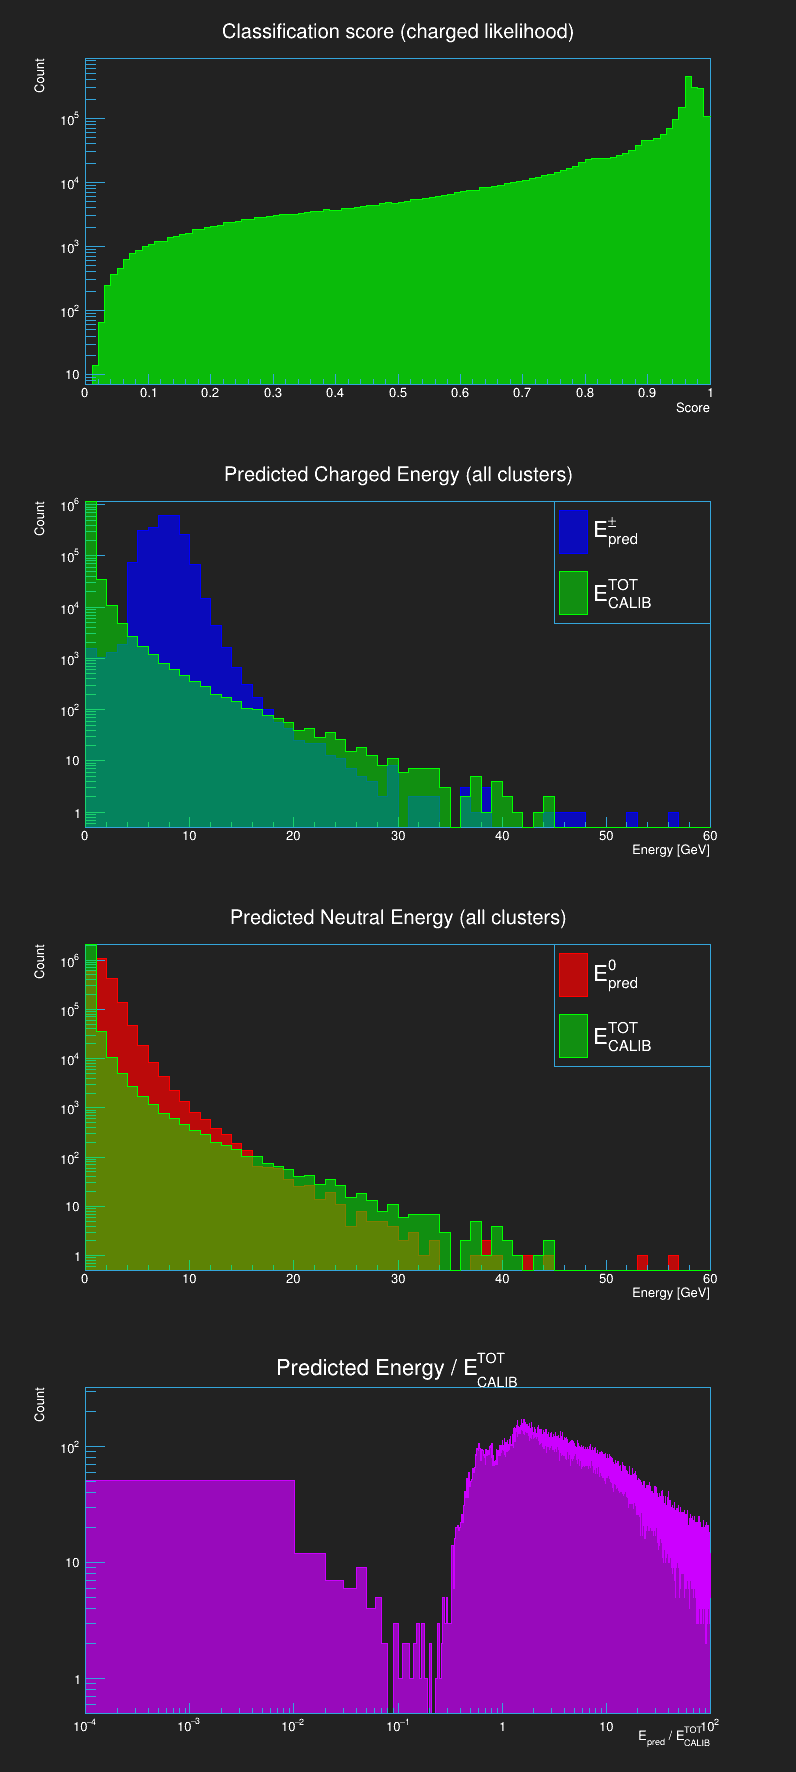

In [13]:
c = rt.TCanvas(str(uuid.uuid4()),'network checks',800,1800)
c.Divide(1,4)

# classification scores
class_hist = rt.TH1F(str(uuid.uuid4()), 'Classification score (charged likelihood);Score;Count',100,0.,1.)
for dfile, trees in ur_trees.items():
    for score in ur_trees[dfile]['score'].array('charged_likelihood_combo'): class_hist.Fill(score)
class_hist.SetFillColorAlpha(rt.kGreen,0.7)
class_hist.SetLineColor(rt.kGreen)
c.cd(1)
class_hist.Draw('HIST')
rt.gPad.SetLogy()

# energy regressions - for all clusters (score-agnostic)

true_e_hist = rt.TH1F(str(uuid.uuid4()), 'E_{CALIB}^{TOT} (all clusters);E_{CALIB}^{TOT} [GeV];Count',60,0.,60.)
charged_hist = rt.TH1F(str(uuid.uuid4()), 'Predicted Charged Energy (all clusters);Energy [GeV];Count',60,0.,60.)
neutral_hist = rt.TH1F(str(uuid.uuid4()), 'Predicted Neutral Energy (all clusters);Energy [GeV];Count',60,0.,60.)

for dfile, trees in ur_trees.items():
    for energy in ur_trees[dfile]['cluster'].array('cluster_ENG_CALIB_TOT'): true_e_hist.Fill(energy)
    for energy in ur_trees[dfile]['score'].array('clusterE_charged'): charged_hist.Fill(energy)
    for energy in ur_trees[dfile]['score'].array('clusterE_neutral'): neutral_hist.Fill(energy)

true_e_hist.SetFillColorAlpha(rt.kGreen,0.5)
true_e_hist.SetLineColor(rt.kGreen)  

charged_hist.SetFillColorAlpha(rt.kBlue,0.7)
charged_hist.SetLineColor(rt.kBlue)  

neutral_hist.SetFillColorAlpha(rt.kRed,0.7)
neutral_hist.SetLineColor(rt.kRed) 

c.cd(2)
leg1 = rt.TLegend(0.7,0.6,0.9,0.9)
leg1.SetTextSize(0.06)
leg1.SetTextColor(plot_style.text)
leg1.AddEntry(charged_hist,'E_{pred}^{#pm}','f')
leg1.AddEntry(true_e_hist,'E_{CALIB}^{TOT}','f')

charged_hist.Draw('HIST')
true_e_hist.Draw('HIST SAME')
leg1.Draw()
rt.gPad.SetLogy()

c.cd(3)
leg2 = rt.TLegend(0.7,0.6,0.9,0.9)
leg2.SetTextSize(0.06)
leg2.SetTextColor(plot_style.text)
leg2.AddEntry(neutral_hist,'E_{pred}^{0}','f')
leg2.AddEntry(true_e_hist,'E_{CALIB}^{TOT}','f')

neutral_hist.Draw('HIST')
true_e_hist.Draw('HIST SAME')
leg2.Draw()
rt.gPad.SetLogy()

# regressed energy (most likely) / calibration hits
zero_energies = 0
n_tot = 0
classification_threshold = 0.5
energy_ratio_hist = rt.TH1F(str(uuid.uuid4()), 'Predicted Energy / E_{CALIB}^{TOT};E_{pred} / E_{CALIB}^{TOT};Count',10000,1.0e-4,1.0e2)
for dfile, trees in ur_trees.items():
    scores = trees['score'].array('charged_likelihood_combo')
    charged_e = trees['score'].array('clusterE_charged')
    neutral_e = trees['score'].array('clusterE_neutral')
    true_e = trees['cluster'].array('cluster_ENG_CALIB_TOT')
    n_tot += len(true_e)
    
    for i in range(len(scores)):
        if(true_e[i] == 0.):
            zero_energies += 1
            continue
        if(scores[i] > 0.5): energy_ratio_hist.Fill(charged_e[i] / true_e[i])
        else: energy_ratio_hist.Fill(neutral_e[i] / true_e[i])

energy_ratio_hist.SetFillColorAlpha(rt.kViolet,0.7)
energy_ratio_hist.SetLineColor(rt.kViolet)
c.cd(4)
energy_ratio_hist.Draw('HIST')
rt.gPad.SetLogx()
rt.gPad.SetLogy()
energy_ratio_hist.GetXaxis().SetRangeUser(1.0e-4, 1.0e2)

rt.gStyle.SetOptStat(0)

print('Number of clusters with ENG_CALIB_TOT == 0: {val1:.2e} ({val2:.2f}% of clusters)'.format(val1 = zero_energies, val2 = 100. * zero_energies / n_tot))

c.SaveAs(plot_dir + '/' + 'cluster_plots.png')
c.Draw()

From the plots above, we see that things are *OK* in that our predicted energies fall within the same range as the targeted ones. However, as the differences between energy distributions (and the last plot, in purple) show, there are an appreciable number of events where our predicted energy is off by and order of magnitude or so. Note that, for the last plot, we're using a classification threshold of $0.5$ (the point in the classifier output where we make the split between topo-clusters classified as charged or neutral). There may be a more optimal choice of cut, but I think it's unlikely that small tweaks to this will totally eliminate the issue we see here.

### Jet clustering

Now, we want to perform jet-clustering, where we'll use the regressed energies (and the classification score will tell us which regressed energy to use for each cluster).

First, let's set up some information on cuts we want to make. 
- We will have a *global* jet $eta$ cut, so that we only consider jets within a certain $eta$ window. We do this as we only have topo-cluster images for topo-clusters with $|\eta| < 0.7$, so we will see some edge effects if performing clustering near that boundary.
- We will apply a *minimum energy cut* on our truth jets. When performing jet matching, we will only be matching reco jets to truth jets that pass this cut.

In [14]:
global_eta_cut = 0.3 # eta cut to be applied to all jets -- those we make and those we're given
global_truth_e_cut = 25. # GeV -- recall that jet energies are stored in MeV!

# pavetext with info on cuts
cut_info = [
    '|#eta_{j}| <' + ' {val:.1f},'.format(val=global_eta_cut),
    'E_{j}^{true}' + ' > {val:.0f} [GeV],'.format(val=global_truth_e_cut),
    'All reco jets matched',
    'to truth w/ #Delta R < 0.3 .'
]

cut_pave = rt.TPaveText(0.675, 0.5, 0.875, 0.7, 'NDC')
cut_pave.SetFillColorAlpha(plot_style.canv,0.1)
cut_pave.SetBorderSize(0)
cut_pave.SetTextColor(plot_style.text)
cut_pave.SetTextFont(42)
cut_pave.SetTextSize(0.03)
cut_pave.SetTextAlign(12)
for line in cut_info: 
    cut_pave.AddText(line)

Now let's perform our jet clustering employing our regressed topo-cluster energies, and save these new jets as `AntiKt4MLTopoJets` in a new tree in each of our files, `JetTree`.

In [15]:
R = 0.4
pt_min = 0.
eta_max = global_eta_cut
classification_threshold = 0.5
tree_name = 'JetTree'

ju.ClusterJets(ur_trees, 
               'AntiKt4MLTopoJets',
               R=R, 
               pt_min = pt_min, 
               eta_max = global_eta_cut, 
               fj_dir = fj_dir, 
               classification_threshold = classification_threshold,
               tree_name = 'JetTree'
)

# update our uproot tree access dictionary, adding our new tree!
tree_names['jet'] = tree_name
ur_trees = {file:{tree_key:ur.open(file)[tree_name] for tree_key,tree_name in tree_names.items()} for file in data_filenames}

#--------------------------------------------------------------------------
#                         FastJet release 3.3.4
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code
# and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


### Jet matching

Now, we want to match the jets we just clustered with the truth jets, to see how well we've reconstructed things.

Here's how we will perform jet-matching:

- Get the list of all reco jets and truth jets for an event
- Loop through the truth jets
    - Find the closest reco jet within $\Delta R=0.3$, if it exists, and call it a match
        - If we fail to find a match, make a note of this
    - Take the matched reco jet off the list, so we don't match it a 2nd time

We will perform this process for all the different reco jet definitions in the files.

Let's save the reco jet matching information to a new tree. A few notes on this information:

-  For each reconstruction-level jet type (EM, LC, ML), we will save a vector of ints for each event. The vector is of the same length as the number of reco jets in that event, and each position will give the index of the truth jet to which that reco jet is matched. Unmatched reco jets will be represented in this vector with a $-1$.
- Any cuts applied to reco jets should be built-in here. If a reco jet fails to pass a reco jet cut, we won't even bother trying to match it (and will label it as unmatched).
- Any cuts on the truth jets should also be built-in here. For example, if we're only considering truth jets with energy > 25 GeV, we are only interested in reco jets that are matched to truth jets that pass this cut. So, we will use that cut when applying the matching, versus just matching any and all jets and worrying about this cut later on. This should make plotting kinematics easier later on, with the caveat that we cannot look at reco jets matched to truth jets that *do not* pass our truth jet cuts, without redoing this step with those cuts removed.

In [16]:
# info on the different jet definitions, and the keys of the trees with which they're associated
jet_defs = {
    'EM':('event', 'AntiKt4EMTopoJets'),
    'LC':('event', 'AntiKt4LCTopoJets'),
    'ML':('jet',   'AntiKt4MLTopoJets'),
    'Truth':('event', 'AntiKt4TruthJets')
}

# explicitly listing the reco jets from above
reco_jet_defs = {
    'EM':('event', 'AntiKt4EMTopoJets'),
    'LC':('event', 'AntiKt4LCTopoJets'),
    'ML':('jet',   'AntiKt4MLTopoJets')
}

# colors, for plotting purposes
colors = {
    'Truth': rt.kViolet,
    'EM': rt.kGreen,
    'LC': rt.kRed,
    'ML': rt.kBlue
}

In [17]:
# Perform jet matching

R = 0.3 # matching radius
tree_name = 'JetMatchTree'

ju.MatchRecoJets(ur_trees,
                 jet_defs = jet_defs, 
                 R = R,
                 eta_max = global_eta_cut, # redundant, this was applied during jet clustering itself
                 truth_e_min = global_truth_e_cut,
                 tree_name = tree_name
                )
   
# update our uproot tree access dictionary, adding our new tree!
tree_names['jet_match'] = tree_name
ur_trees = {file:{tree_key:ur.open(file)[tree_name] for tree_key,tree_name in tree_names.items()} for file in data_filenames}

Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/jets/../jets/Plots/jet_energy_ratio.png has been created


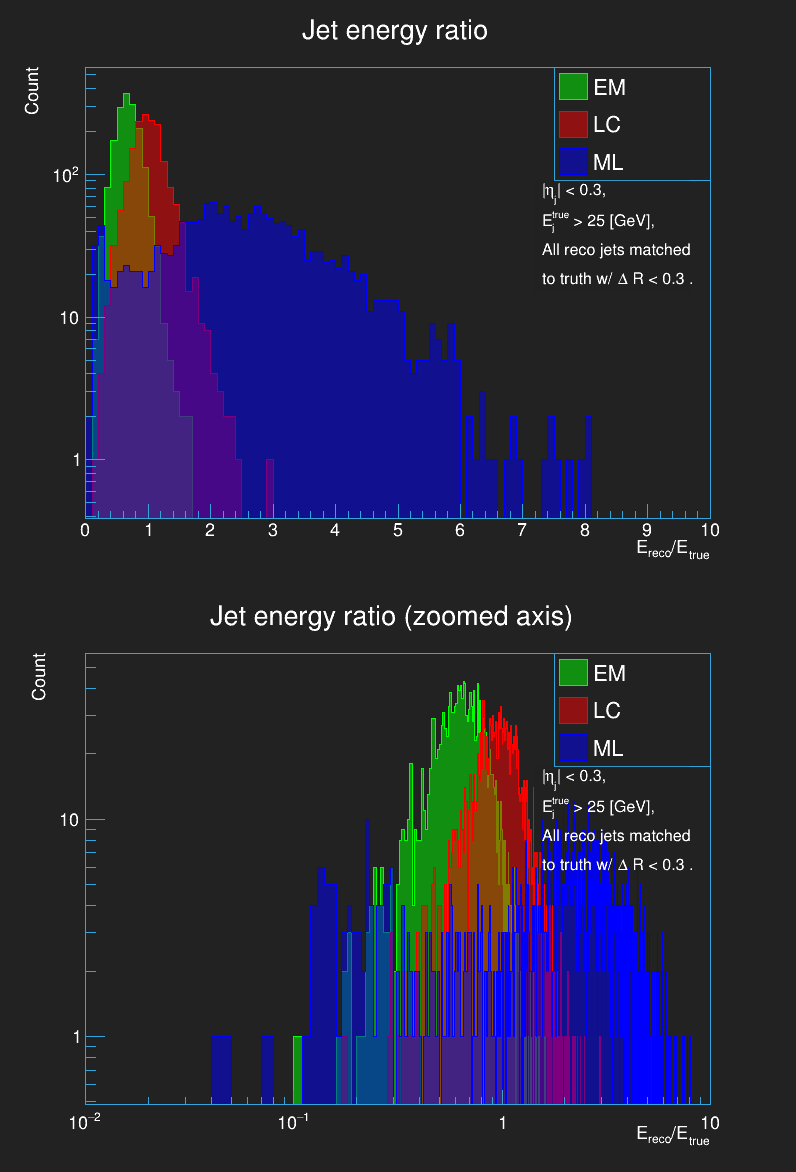

In [18]:
# Plot energy ratios
results = ju.PlotEnergyRatio(ur_trees,
                             reco_jet_defs = reco_jet_defs,
                             colors = colors,
                             truth_jet_def='AntiKt4TruthJets',
                             match_key='jet_match',
                             min_ratio = 0.,
                             max_ratio = 10.,
                             nbins = 100,
                             paves = [cut_pave],
                             plot_dir = plot_dir
                            )

Some of the stuff we're seeing above looks weird. Many of the cluster energies are too low, but there's also a very large tail to the distribution.

But even with this rescaling having been done, we see issues such as in the plot above.

## Jet Kinematic distributions

To get a better sense of what our data looks like, let's produce some kinematic plots for all flavors of jets. We'll see how the different jet definitions' kinematics compare, and if something is off with our ML jets.

For our reco jets, we will only be considering those that have been matched with truth jets.

Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/jets/../jets/Plots/energy.png has been created
Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/jets/../jets/Plots/pt.png has been created
Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/jets/../jets/Plots/eta.png has been created
Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/jets/../jets/Plots/ep.png has been created
Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/jets/../jets/Plots/m.png has been created
Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/jets/../jets/Plots/n.png has been created


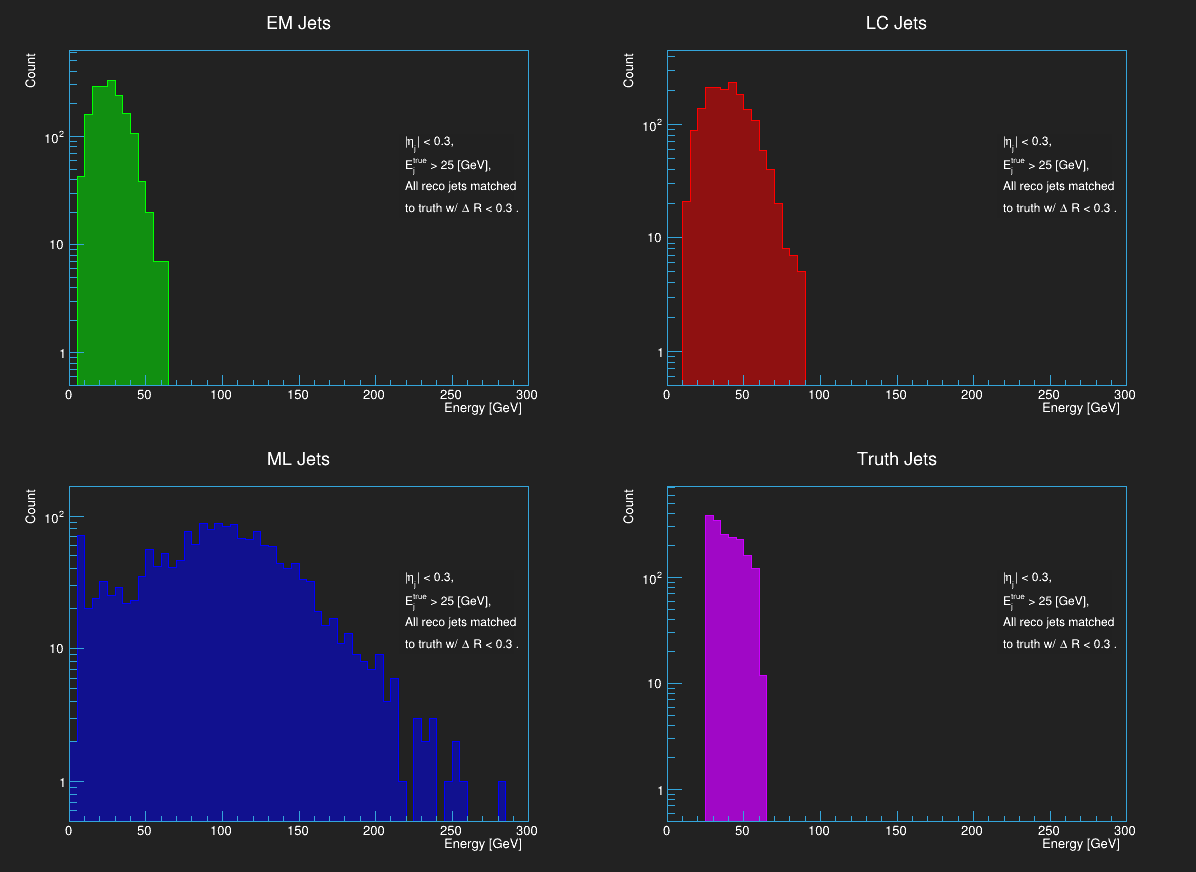

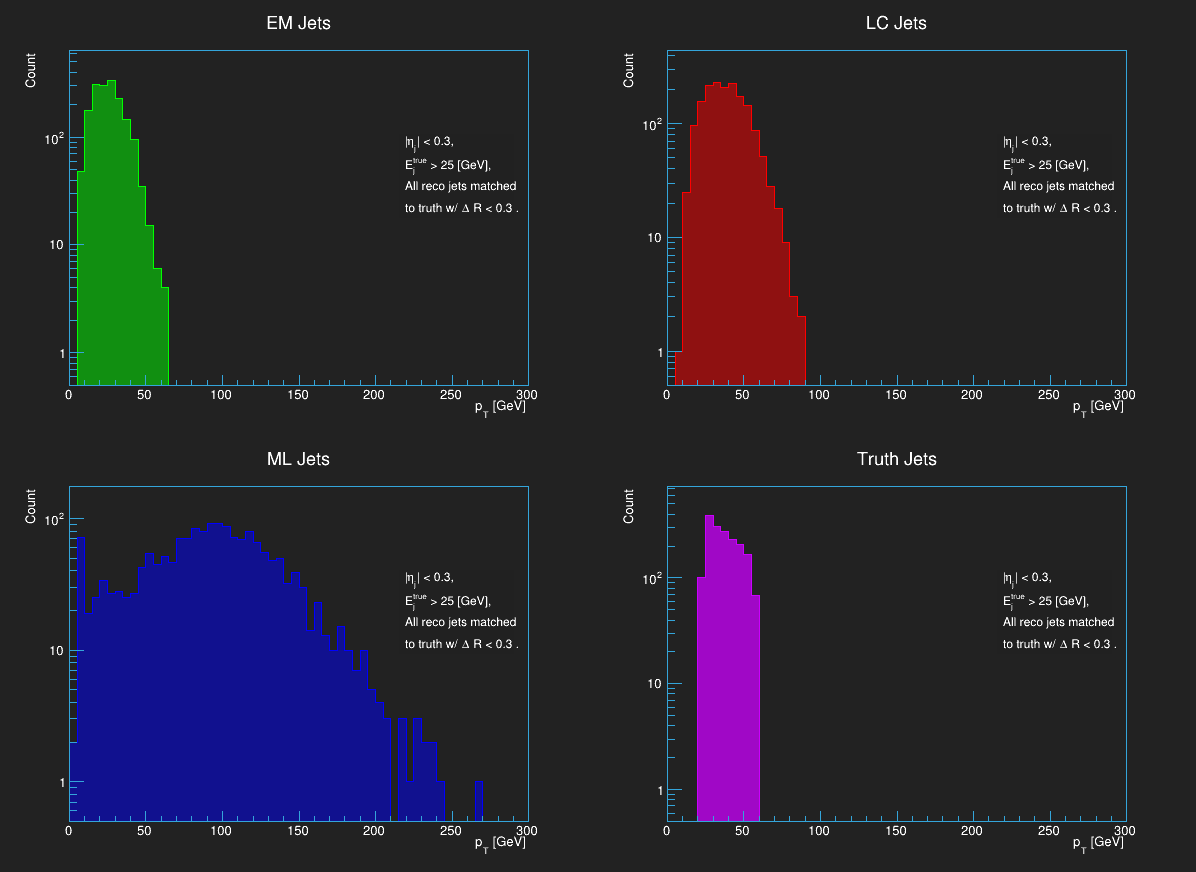

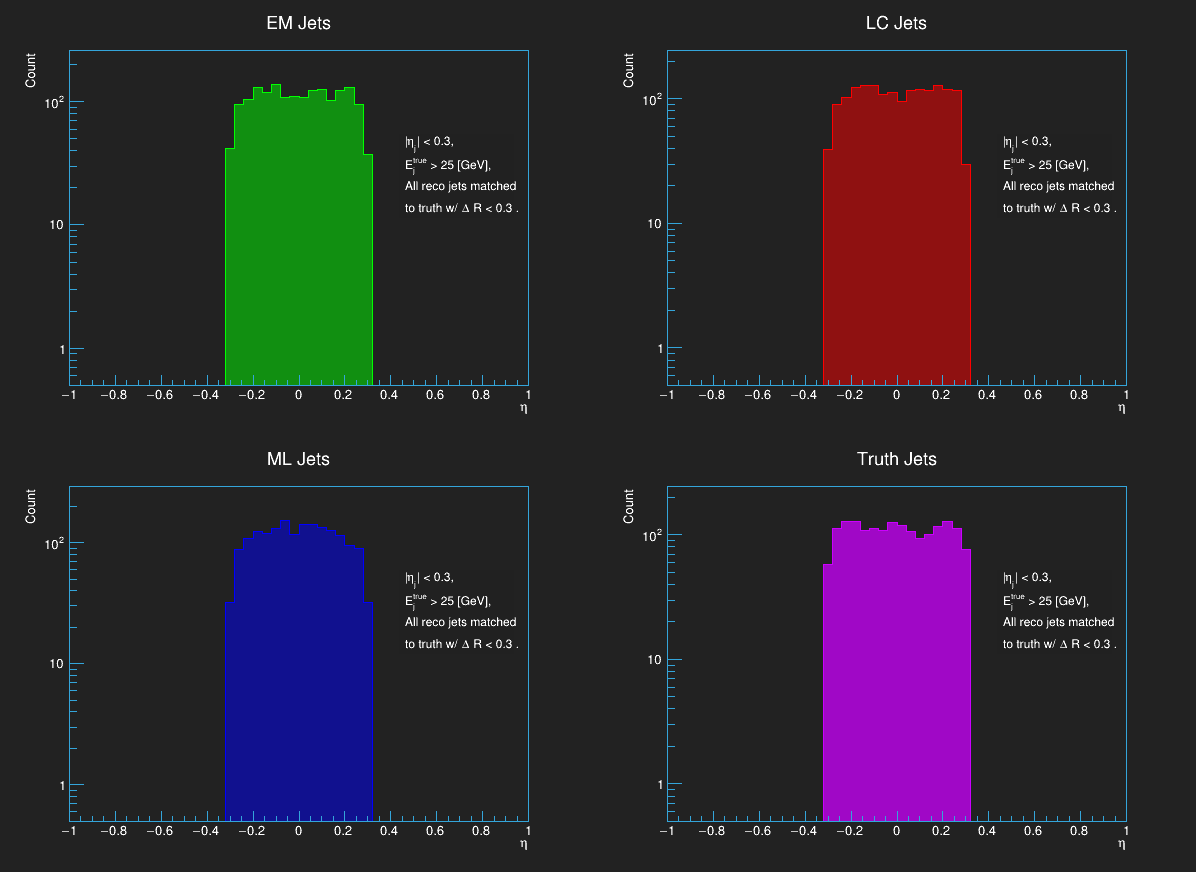

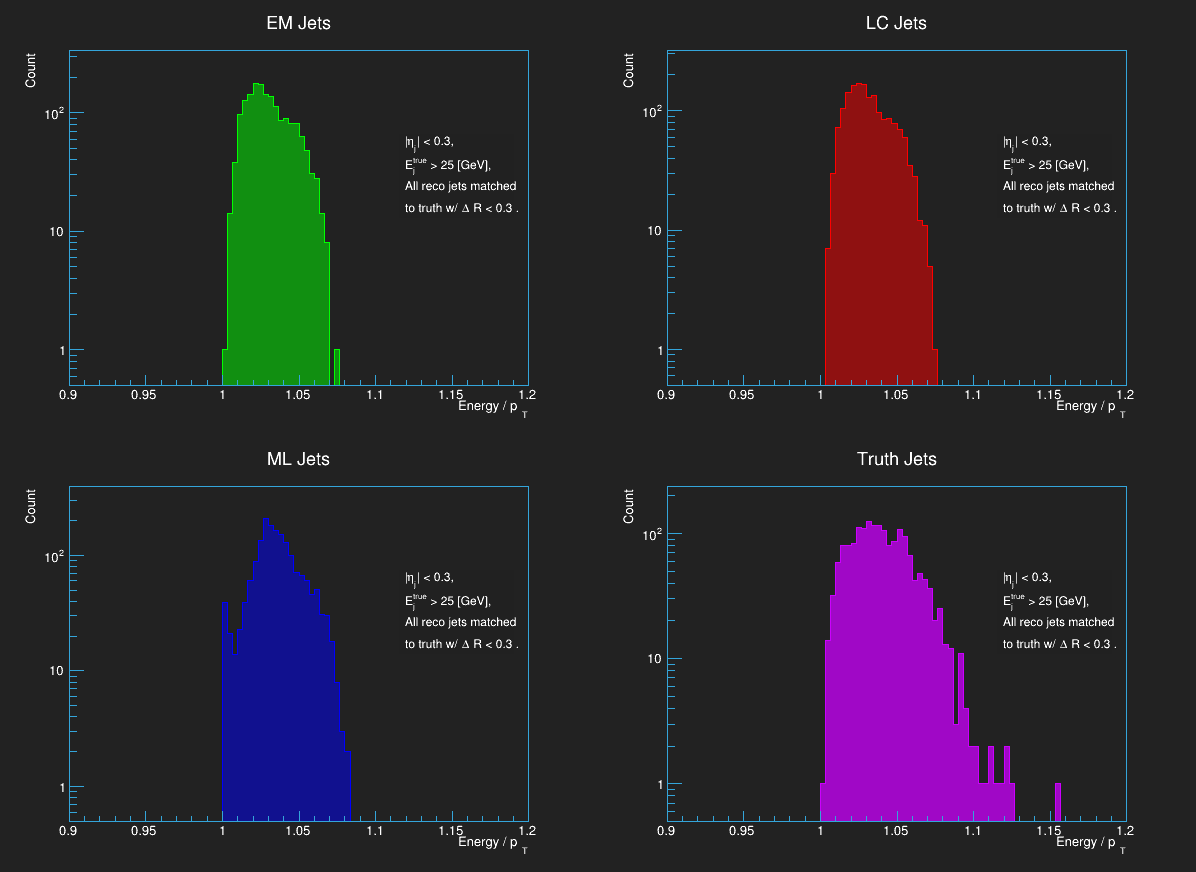

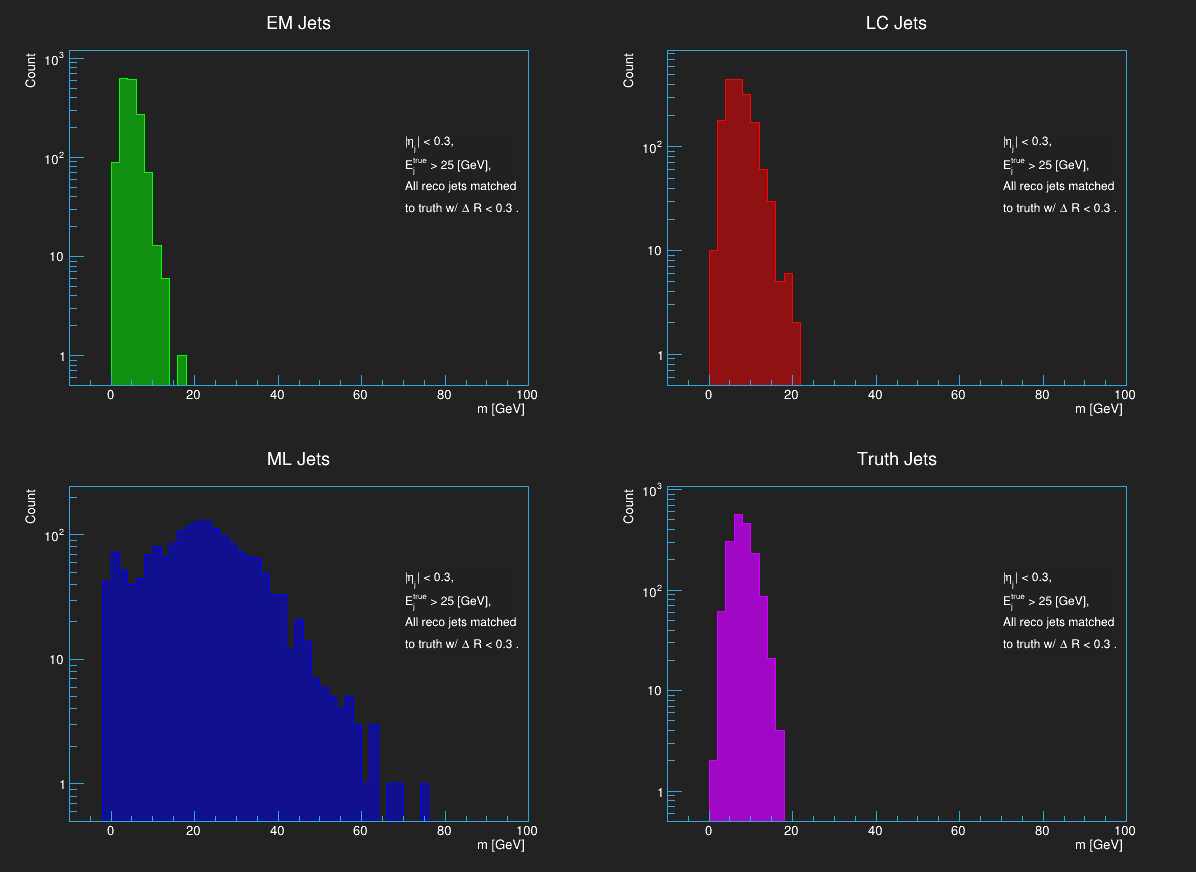

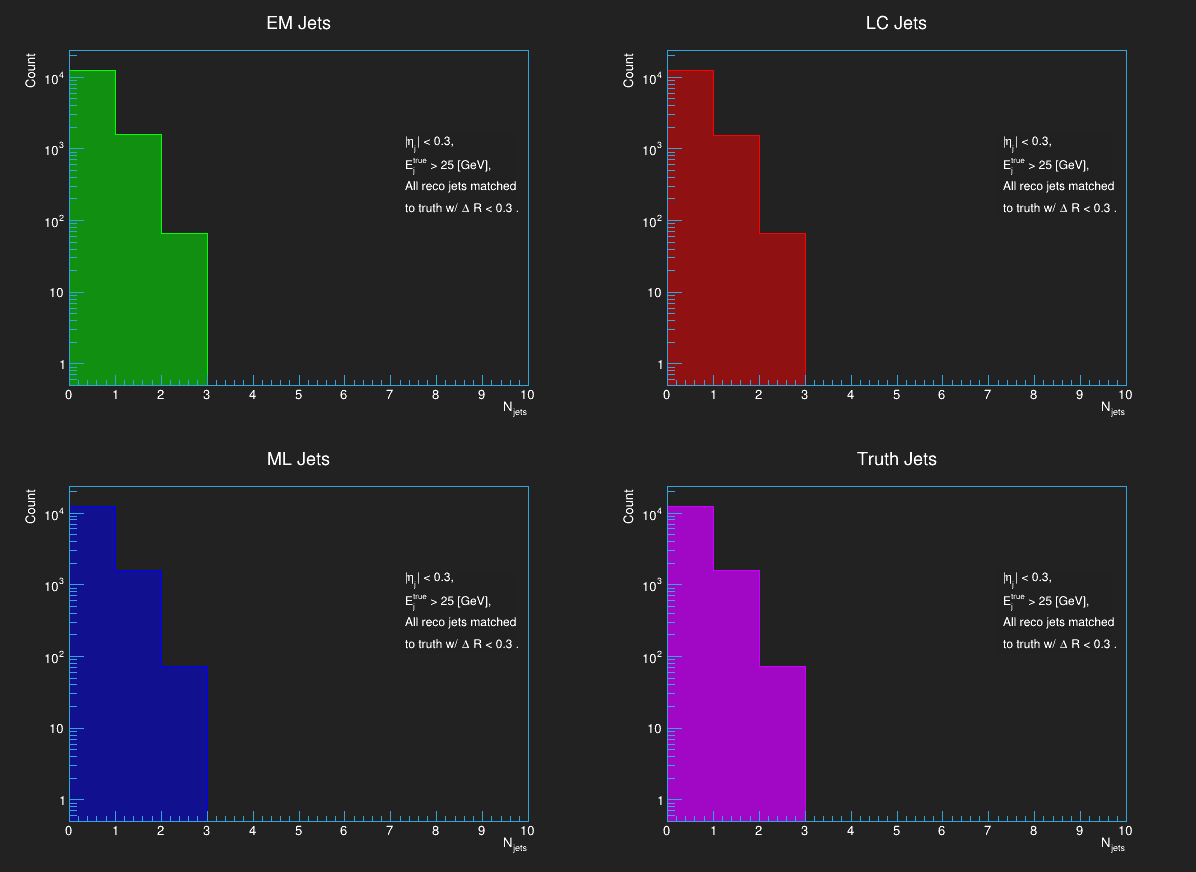

In [19]:
results = ju.PlotJetKinematics(ur_trees,
                               jet_defs = jet_defs,
                               colors = colors,
                               plot_dir = plot_dir,
                               eta_max = global_eta_cut,         # used for cut on truth jets, reco jets will already have cuts applied via matching
                               truth_e_min = global_truth_e_cut, # used for cut on truth jets, reco jets will already have cuts applied via matching
                               paves = [cut_pave],
                               logx = [] # names of variables to be plotted with log scale on x axis, see jet_util.py for name conventions
                              )

The energies for the ML jets don't look great -- as we might expect, the issues with the cluster energies (mostly being way too small, and a few being way too large) is carrying over to jet clustering.

### Verifying jet clustering

For completeness, we should make sure that the jet clustering above is working properly at all. To do this, we can try to reproduce the EM jets, which just use the `clusterE` branch for their topo-cluster energies.

##### Reproducing EM jets

This code will look a lot like our jet clustering above, but we will be using the default reco energy. We'll save our new EM jets to a tree called `JetTree_EM`.

Note that we *will* apply a $5$ GeV minimum $p_T$ cut to the jets that we produce, as we can see that this was applied to the original EM jets and we're trying to reproduce those results.

In [20]:
R = 0.4
pt_min = 5. # GeV
eta_max = global_eta_cut
tree_name = 'JetTree_EM'

ju.ClusterJets(ur_trees, 
               'AntiKt4EMTopoJets',
               R=R, 
               pt_min = pt_min, 
               eta_max = global_eta_cut, 
               fj_dir = fj_dir, 
               tree_name = tree_name,
               energy_tree_key = 'cluster',
               energy_branch = 'clusterE'
)

In [21]:
# update our uproot tree access dictionary, adding our new tree!
tree_names['jet_em'] = tree_name
ur_trees = {file:{tree_key:ur.open(file)[tree_name] for tree_key,tree_name in tree_names.items()} for file in data_filenames}

We *also* need to match our new `EM2` jets to truth jets, for a fair comparison with the `EM` jets. We will save the matching info to `JetMatchTree_EM`.

In [22]:
# info on the different jet definitions, and the keys of the trees with which they're associated
jet_defs = {
    'EM':('jet_em', 'AntiKt4EMTopoJets'),
    'Truth':('event', 'AntiKt4TruthJets')
}
R = 0.3 # matching radius
tree_name = 'JetMatchTree_EM'

ju.MatchRecoJets(ur_trees, 
              jet_defs = jet_defs, 
              R = R,
              eta_max = global_eta_cut, # redundant, this was applied during jet clustering itself
              truth_e_min = global_truth_e_cut,
              tree_name = tree_name
             )
   
# update our uproot tree access dictionary, adding our new tree!
tree_names['jet_match_em'] = tree_name
ur_trees = {file:{tree_key:ur.open(file)[tree_name] for tree_key,tree_name in tree_names.items()} for file in data_filenames}

Now let's plot the kinematic distributions of our new EM jets and the old EM jets. Our hope is that they match. Note that we might expect to find some lower $p_T$ jets too, as it looks like a $p_T$ cut was applied to the original EM jets and we aren't necessarily applying one here.

Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/jets/../jets/Plots/verification_em.png has been created


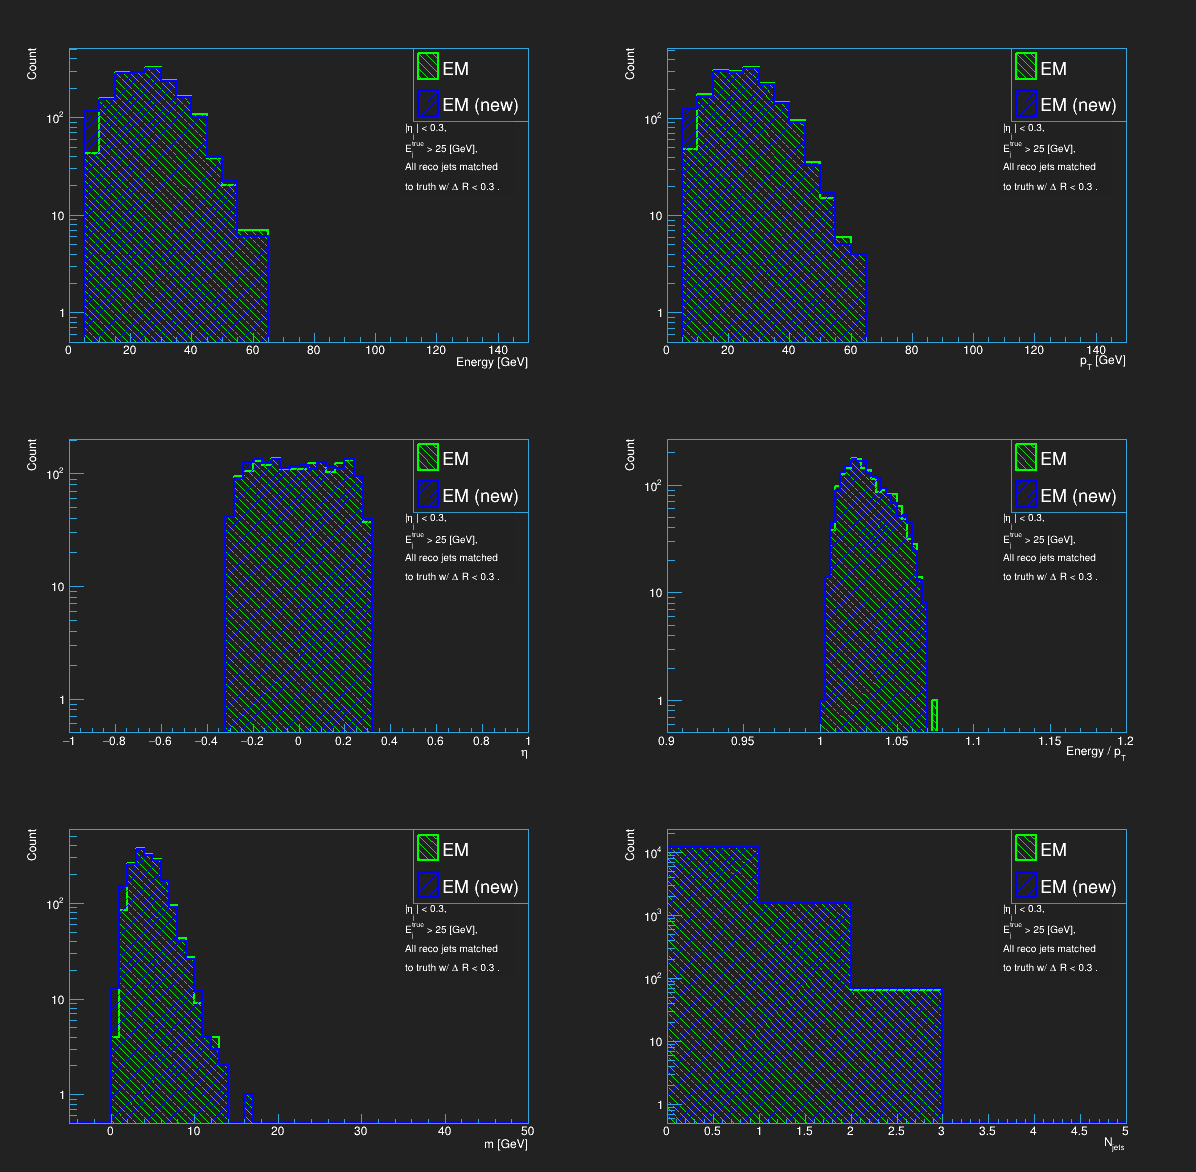

In [23]:
jet_defs = {
    'EM':('event', 'AntiKt4EMTopoJets'),
    'EM2':('jet_em', 'AntiKt4EMTopoJets'),
}

colors = {
    'EM': rt.kGreen,
    'EM2': rt.kBlue
}

scale_factors = 0.001 # jet info is in MeV, we want to plot it all in GeV
energy_hists = {key:rt.TH1F(str(uuid.uuid4()), key + ' Jets;Energy [GeV];Count', 30, 0., 150.) for key in jet_defs.keys()}
pt_hists     = {key:rt.TH1F(str(uuid.uuid4()), key + ' Jets;p_{T} [GeV];Count', 30, 0., 150.) for key in jet_defs.keys()}
eta_hists    = {key:rt.TH1F(str(uuid.uuid4()), key + ' Jets;#eta;Count', 50, -1., 1.) for key in jet_defs.keys()}
m_hists      = {key:rt.TH1F(str(uuid.uuid4()), key + ' Jets;m [GeV];Count', 55, -5., 50.) for key in jet_defs.keys()}
ep_hists     = {key:rt.TH1F(str(uuid.uuid4()), key + ' Jets;Energy / p_{T};Count', 90, 0.9, 1.2) for key in jet_defs.keys()}
n_hists      = {key:rt.TH1I(str(uuid.uuid4()), key + ' Jets;N_{jets};Count', 5, 0, 5) for key in jet_defs.keys()}

vec = rt.Math.PtEtaPhiEVector()
for dfile, tree in ur_trees.items():
    for key, jet_def in jet_defs.items():
        tkey  = jet_def[0]
        jname = jet_def[1]
        
        # Truth jets -- apply global jet cuts, and truth-specific jet cuts.
        if(key == 'Truth'):
            eta = tree[tkey].array(jname + 'Eta')
            energy = tree[tkey].array(jname + 'E')
            # Truth jet energy cut & jet eta cut.
            jet_indices = (np.abs(eta) <= global_eta_cut) * (energy  >= 1.0e3 * global_truth_e_cut)
        
        # Reco jets -- apply jet-matching cut (global jet cuts are built-in). No further reco-specific jet cuts for now.
        else:
            jmatch_key = 'jet_match'
            if(key == 'EM2'): jmatch_key = 'jet_match_em'
            matching = tree[jmatch_key].array(jname + 'Match')
            jet_indices = (matching > -1)
            
        # Now get all jets that passed the cuts.
        # First do a bit of manipulation with eta, to also get the number of jets per event.
        eta = tree[tkey].array(jname + 'Eta')[jet_indices]
        n   = [len(x) for x in eta]
        eta = eta.flatten()
        energy = scale_factors * tree[tkey].array(jname + 'E')[jet_indices].flatten()
        pt     = scale_factors * tree[tkey].array(jname + 'Pt')[jet_indices].flatten()
        ep     = energy / pt
        
        for i in range(len(n)): n_hists[key].Fill(n[i])
            
        for i in range(len(ep)):
            energy_hists[key].Fill(energy[i])
            pt_hists[key].Fill(pt[i])
            eta_hists[key].Fill(eta[i])
            ep_hists[key].Fill(ep[i])
            
            # Compute the jet mass and plot it too.
            vec.SetCoordinates(pt[i],eta[i],0.,energy[i])
            m_hists[key].Fill(vec.M())

hist_lists = [energy_hists, pt_hists, eta_hists, ep_hists, m_hists, n_hists]
names      = ['energy',     'pt',     'eta',     'ep',     'm',     'n']
styles = { 'EM': 3345,  'EM2': 3354}# fill styles
for key in jet_defs.keys():
    for hist_list in hist_lists:
        qu.SetColor(hist_list[key],colors[key],alpha = 0.9)
        hist_list[key].SetFillStyle(styles[key])
        hist_list[key].SetLineWidth(2)
            
legend = rt.TLegend(0.7,0.7,0.9,0.9)
legend.SetTextColor(plot_style.text)
legend.AddEntry(energy_hists['EM'],'EM','f')
legend.AddEntry(energy_hists['EM2'],'EM (new)','f')

rt.gStyle.SetOptStat(0)
nx = 2
l = len(hist_lists)
ny = int(np.ceil(l / nx))
c = rt.TCanvas(str(uuid.uuid4()), str(uuid.uuid4()), nx * 600, ny * 400)
c.Divide(nx,ny)

stacks = []
for i in range(len(hist_lists)):
    c.cd(i+1)
    hist_list = hist_lists[i]
    rt.gPad.SetLogy()
    stack = rt.THStack(str(uuid.uuid4()),'')
    #stack.SetTitle(list(hist_list.values())[0].GetTitle())
    for key in hist_list.keys():
        stack.Add(hist_list[key])
    stack.Draw('NOSTACK HIST')
    legend.Draw()
    cut_pave.Draw()
    stack.GetXaxis().SetTitle(list(hist_list.values())[0].GetXaxis().GetTitle())
    stack.GetYaxis().SetTitle(list(hist_list.values())[0].GetYaxis().GetTitle())
    stack.SetMinimum(5.0e-1)
    stacks.append(stack)
c.Draw()
c.SaveAs(plot_dir + '/' + 'verification_em.png')

We do see some small differences in distributions. For example, the smallest non-zero bin in the energy and $p_T$ distributions. 

I'm not entirely sure how to account for this difference: We are applying our jet-matching criteria and cuts to *both* sets of jets being plotted here -- the EM jets that we were given and the ones that we re-clustered ourselves. Looking through the clustering code we have, the logic seems pretty sound to me and it looks like it almost perfectly reproduces the distributions. 
- Could edge effects be playing some small role? We don't have topo-cluster info saved for topo-clusters with $|\eta| > 0.7$. We tried to account for this by applying a jet cut of $|\eta_j| < 0.3$, but is it possible that the missing topo-clusters could still be having a small effect on our reclustering of EM jets? The only alternative I could think of is some cut being applied to the EM jets, that I haven't incorporated when re-clustering them.

#### Understanding effects of overlapping topo-clusters: Looking at isolated topo-clusters

From the above, we've seen that
- our ML topo-clusters have an energy distribution that is too spread out.
- our ML jets also have an energy distribution is very spread out.
- our jet clustering itself appears to be functioning properly.

It's possible that our ML jets aren't performing well due to some difference in conditions between the networks' training samples -- our "pion dataset" -- and the jet dataset that we're looking at. For example, we may be seeing a higher incidence of topo-clusters that overlap, as we are dealing with jets versus single pions. To see if this is the case, we might try to look for "isolated topo-clusters" -- those that are well-separated from others in $(\eta, \phi)$ -- and see if our energy regression is reconstructing their energies better than it's doing for the dataset as a whole.

First, let's see a distribution of the minimum $\Delta R$ for each topo-cluster (i.e. looking for the distances to the nearest topo-cluster).

**Note**: Rather than invoke `ROOT.Math.PtEtaPhiEVector` and `ROOT.Math.VectorUtil.DeltaR()`, we're going to re-implement these methods in `numpy` + `numba`, as this appears to give a big speedup when compared to just using `PyROOT`.

In [24]:
@jit
def dPhi(phi1, phi2):
    dphi = phi2 - phi1
    if(dphi > np.pi): dphi -= 2. * np.pi
    elif(dphi < -np.pi): dphi += 2. * np.pi
    return dphi

@jit
def dR(eta1,eta2,phi1,phi2):
    return np.sqrt(np.power(eta2 - eta1, 2) + np.power(dPhi(phi1,phi2),2))

In [25]:
# name for the tree where we will store minimum dR
tree_name = 'ClusterDistanceTree'

# Prepare our progress bar.
nevents = 0
for dfile, tree in ur_trees.items():
    cluster_min = tree['event'].array('clusterCount')
    nevents += len(cluster_min)
m = 0
l = nevents
prefix = 'Computing minimum dR:'
suffix = 'Complete'
if(not skip_dR): qu.printProgressBarColor(m, l, prefix=prefix, suffix=suffix, length=50)
for dfile, tree in ur_trees.items():
    if(skip_dR): continue
    # eta and phi for all clusters in file (across events)
    eta = tree['cluster'].array('clusterEta')
    phi = tree['cluster'].array('clusterPhi')

    # event info
    cluster_min = tree['event'].array('clusterCount')
    cluster_max = cluster_min + tree['event'].array('nCluster') - 1
    
    # Prepare the new tree
    branch_buffer = {
        'MinDeltaR':rt.std.vector('float')()
    }
    f = rt.TFile(dfile,'UPDATE')
    t = rt.TTree(tree_name, tree_name)
    branches = {}
    for key,val in branch_buffer.items(): branches[key] = t.Branch(key, val)
        
    # loop over events
    n = len(cluster_min)
    for i in range(n):
        branch_buffer['MinDeltaR'].clear()
        nCluster = cluster_max[i] - cluster_min[i] + 1

        distances = np.zeros((nCluster,nCluster))
        for j in range(nCluster):
            for k in range(j):
                distances[j,k] = dR(eta[j],phi[j],eta[k],phi[k])
                distances[k,j] = distances[j,k]
            distances[j,j] = 999. # easy way to eliminate the diagonal, which we do not want to consider.
        
        # Now loop through rows (or columns), pick the minimum from each.
        min_distances = np.array([np.min(distances[j]) for j in range(nCluster)])
        for entry in min_distances: 
            branch_buffer['MinDeltaR'].push_back(entry)
            
        t.Fill()
        m += 1
        qu.printProgressBarColor(m, l, prefix=prefix, suffix=suffix, length=50)
    t.Write(tree_name,rt.TObject.kOverwrite)
    f.Close()
# update our uproot tree access dictionary, adding our new tree!
tree_names['cluster_dist'] = tree_name
ur_trees = {file:{tree_key:ur.open(file)[tree_name] for tree_key,tree_name in tree_names.items()} for file in data_filenames}

Now let's plot the distribution of the minimum $\Delta R$ between topo-clusters, as well as the ratio of $E_\text{pred}$ to $E_\text{calib}^\text{tot}$, as a function of this minimum $\Delta R$.

Note that we're looking at *all* topo-clusters in our testing data. This will potentially include clusters that were used in jets that we discarded -- because they didn't pass our cuts -- but we do not currently save the $\text{cluster} \leftrightarrow \text{jet}$ mapping that would let us easily discard such clusters.

Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/jets/../jets/Plots/cluster_min_dR.png has been created
Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/jets/../jets/Plots/cluster_min_dR_vs_energy.png has been created
Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/jets/../jets/Plots/cluster_min_dR_vs_energy_norm.png has been created


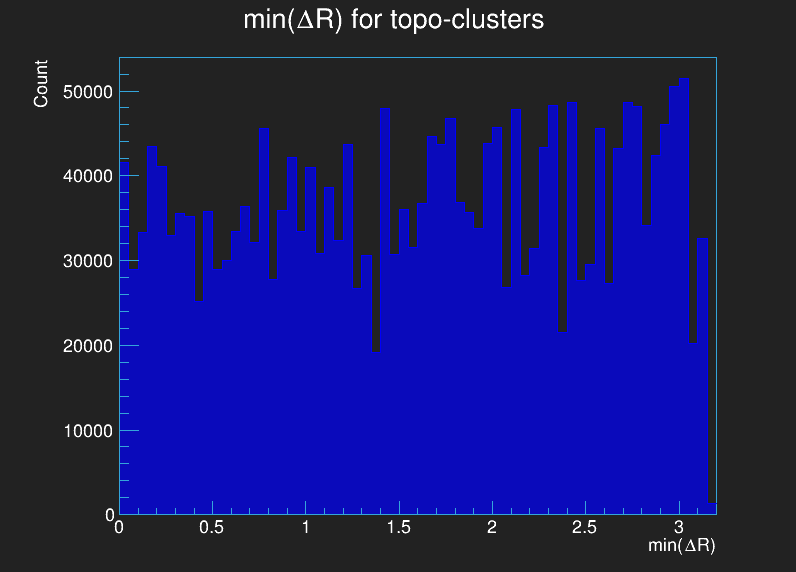

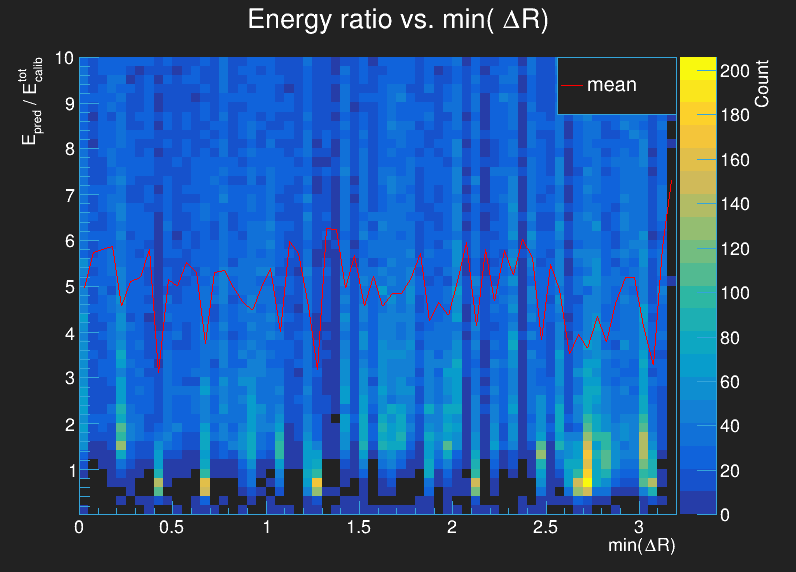

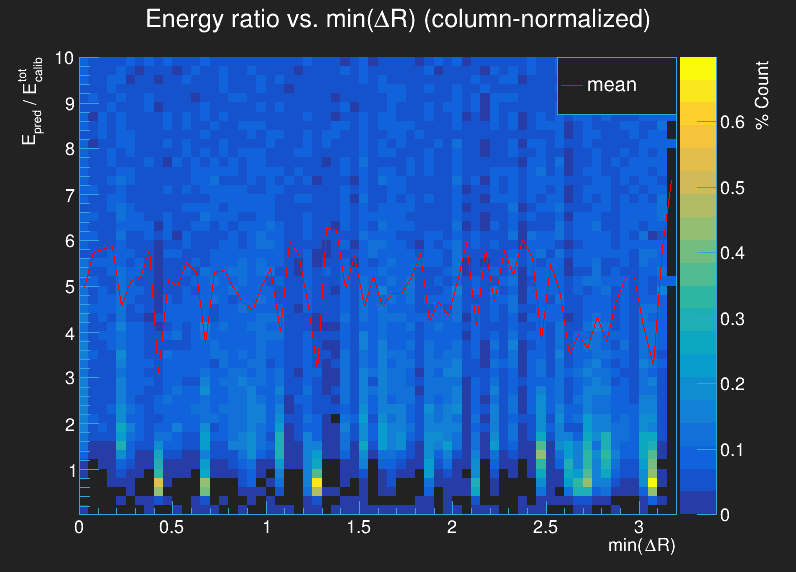

In [26]:
hist_ranges = {
    'dR':(64,0.,3.2),
    'E_ratio':(50,0.01,10.)
}

# Distribution of minimum dR for topo-clusters.
c = rt.TCanvas(str(uuid.uuid4()), 'cluster_distances', 800, 600)
c.SetLeftMargin(0.15)
h = rt.TH1F(str(uuid.uuid4()), 'min(#DeltaR) for topo-clusters;min(#DeltaR);Count', hist_ranges['dR'][0],hist_ranges['dR'][1],hist_ranges['dR'][2])
h.SetLineColor(rt.kBlue)
h.SetFillColorAlpha(rt.kBlue,0.7)
for dfile, tree in ur_trees.items():
    min_distances = tree['cluster_dist'].array('MinDeltaR').flatten()
    for entry in min_distances: h.Fill(entry)
h.Draw()
c.Draw()
c.SaveAs(plot_dir + '/' + 'cluster_min_dR.png')

# Energy ratio as a function of minimum dR.
# We'll also make a column-normalized version of this plot.
classification_threshold = 0.5

h2 = rt.TH2F(str(uuid.uuid4()), 'Energy ratio vs. min(#DeltaR);min(#DeltaR);E_{pred} / E_{calib}^{tot};Count',hist_ranges['dR'][0],hist_ranges['dR'][1],hist_ranges['dR'][2],hist_ranges['E_ratio'][0],hist_ranges['E_ratio'][1],hist_ranges['E_ratio'][2])
h3 = rt.TH2F(str(uuid.uuid4()), 'Energy ratio vs. min(#DeltaR) (column-normalized);min(#DeltaR);E_{pred} / E_{calib}^{tot};% Count',hist_ranges['dR'][0],hist_ranges['dR'][1],hist_ranges['dR'][2],hist_ranges['E_ratio'][0],hist_ranges['E_ratio'][1],hist_ranges['E_ratio'][2])

for dfile, tree in ur_trees.items():
    min_distances = tree['cluster_dist'].array('MinDeltaR'                       ).flatten()
    scores        = tree['score'       ].array('charged_likelihood_combo'        ).flatten()
    charged_e     = tree['score'       ].array('clusterE_charged'                ).flatten()
    neutral_e     = tree['score'       ].array('clusterE_neutral'                ).flatten()
    eng_calib_tot = tree['cluster'     ].array('cluster_ENG_CALIB_TOT'           ).flatten()
    
    # Get predicted energies, using classification.
    e_ratio = np.copy(charged_e)
    e_ratio[scores < classification_threshold] = neutral_e[scores < classification_threshold]
    e_ratio[eng_calib_tot == 0.] = 0.
    eng_calib_tot[eng_calib_tot == 0.] = 1.
    e_ratio = e_ratio / eng_calib_tot
    
    n = len(scores)
    for i in range(n): 
        h2.Fill(min_distances[i],e_ratio[i])
        h3.Fill(min_distances[i],e_ratio[i])
        
# We will normalize one of these plots, so that each column of bins sums to 1.
# To do this, we get the 2D histogram's profile along X. This may not necessarily
# match our 1D histogram from above, as our given E_ratio range may cause some things
# to land in underflow/overflow.
projx = h3.ProjectionX()
    
for i in range(projx.GetNbinsX()):
    integral = projx.GetBinContent(i+1)
    for j in range(h3.GetNbinsY()):
        h3.SetBinContent(i+1,j+1, 100. * h3.GetBinContent(i+1,j+1) / integral)

# We also want to mark where the mean is for each column.
profx = h2.ProfileX()
profx.SetLineColor(rt.kRed)

markers = []
for i in range(profx.GetNbinsX()):
    x = profx.GetBinCenter(i+1)
    y = profx.GetBinContent(i+1)
    r = 0.25 * profx.GetBinWidth(i+1)
    marker = rt.TEllipse(x,y,r)
    marker.SetLineColor(rt.kRed)
    marker.SetFillColor(rt.kRed)
    markers.append(marker)
            
c2 = rt.TCanvas(str(uuid.uuid4()), 'energy_dR', 800, 600)
c2.SetRightMargin(0.15)

c3 = rt.TCanvas(str(uuid.uuid4()), 'energy_dR', 800, 600)
c3.SetRightMargin(0.15)

legend = rt.TLegend(0.7,0.8,0.85,0.9)
legend.AddEntry(profx,'mean','l')
legend.SetTextColor(plot_style.text)

c2.cd()
h2.Draw('COLZ')
profx.Draw('HIST L SAME')
legend.Draw()
c2.Draw()
c2.SaveAs(plot_dir + '/' + 'cluster_min_dR_vs_energy.png')

c3.cd()
h3.Draw('COLZ')
profx.Draw('HIST L SAME')
legend.Draw()
c3.Draw()
c3.SaveAs(plot_dir + '/' + 'cluster_min_dR_vs_energy_norm.png')

There doesn't seem to be a strong correlation between the ratio of a topo-cluster's predicted energy to its calibration hits, and the minimum distance to the nearest topo-cluster. We could consider looking at the median but I don't think this will be enlightening.

Note that I've excluded the zero bin on the y-axis, as this contains a very large number of entries corresponding to the case of $E_\text{calib}^\text{tot} = 0$.

## Additional verification

### 1) Looking at topo-cluster kinematics for training (pion gun) and testing (jet) samples.

It's worthwhile to look at differences in the kinematics -- beyond different conditions between samples, e.g. overlapping, very different kinematics could result in poorer performance.

In [27]:
# our training data
training_data_filenames = {'pp':training_data_dir+'/piplus.root','pm':training_data_dir+'/piminus.root','p0':training_data_dir+'/pi0.root'}
training_trees = {key:ur.open(val)['ClusterTree'] for key, val in training_data_filenames.items()}

# training cuts: During training, we discarded some data, so we will do the same here.
energy_cut = 5.0e-1 # GeV, cut on cluster_ENG_CALIB_TOT
training_indices = {key:tree.array('cluster_ENG_CALIB_TOT').flatten() for key, tree in training_trees.items()}
training_indices = {key:val>energy_cut for key, val in training_indices.items()}

Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/jets/../jets/Plots/cluster_pt.png has been created
Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/jets/../jets/Plots/cluster_e.png has been created
Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/jets/../jets/Plots/cluster_eta.png has been created
Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/jets/../jets/Plots/cluster_phi.png has been created
Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/jets/../jets/Plots/cluster_eng_calib_tot.png has been created


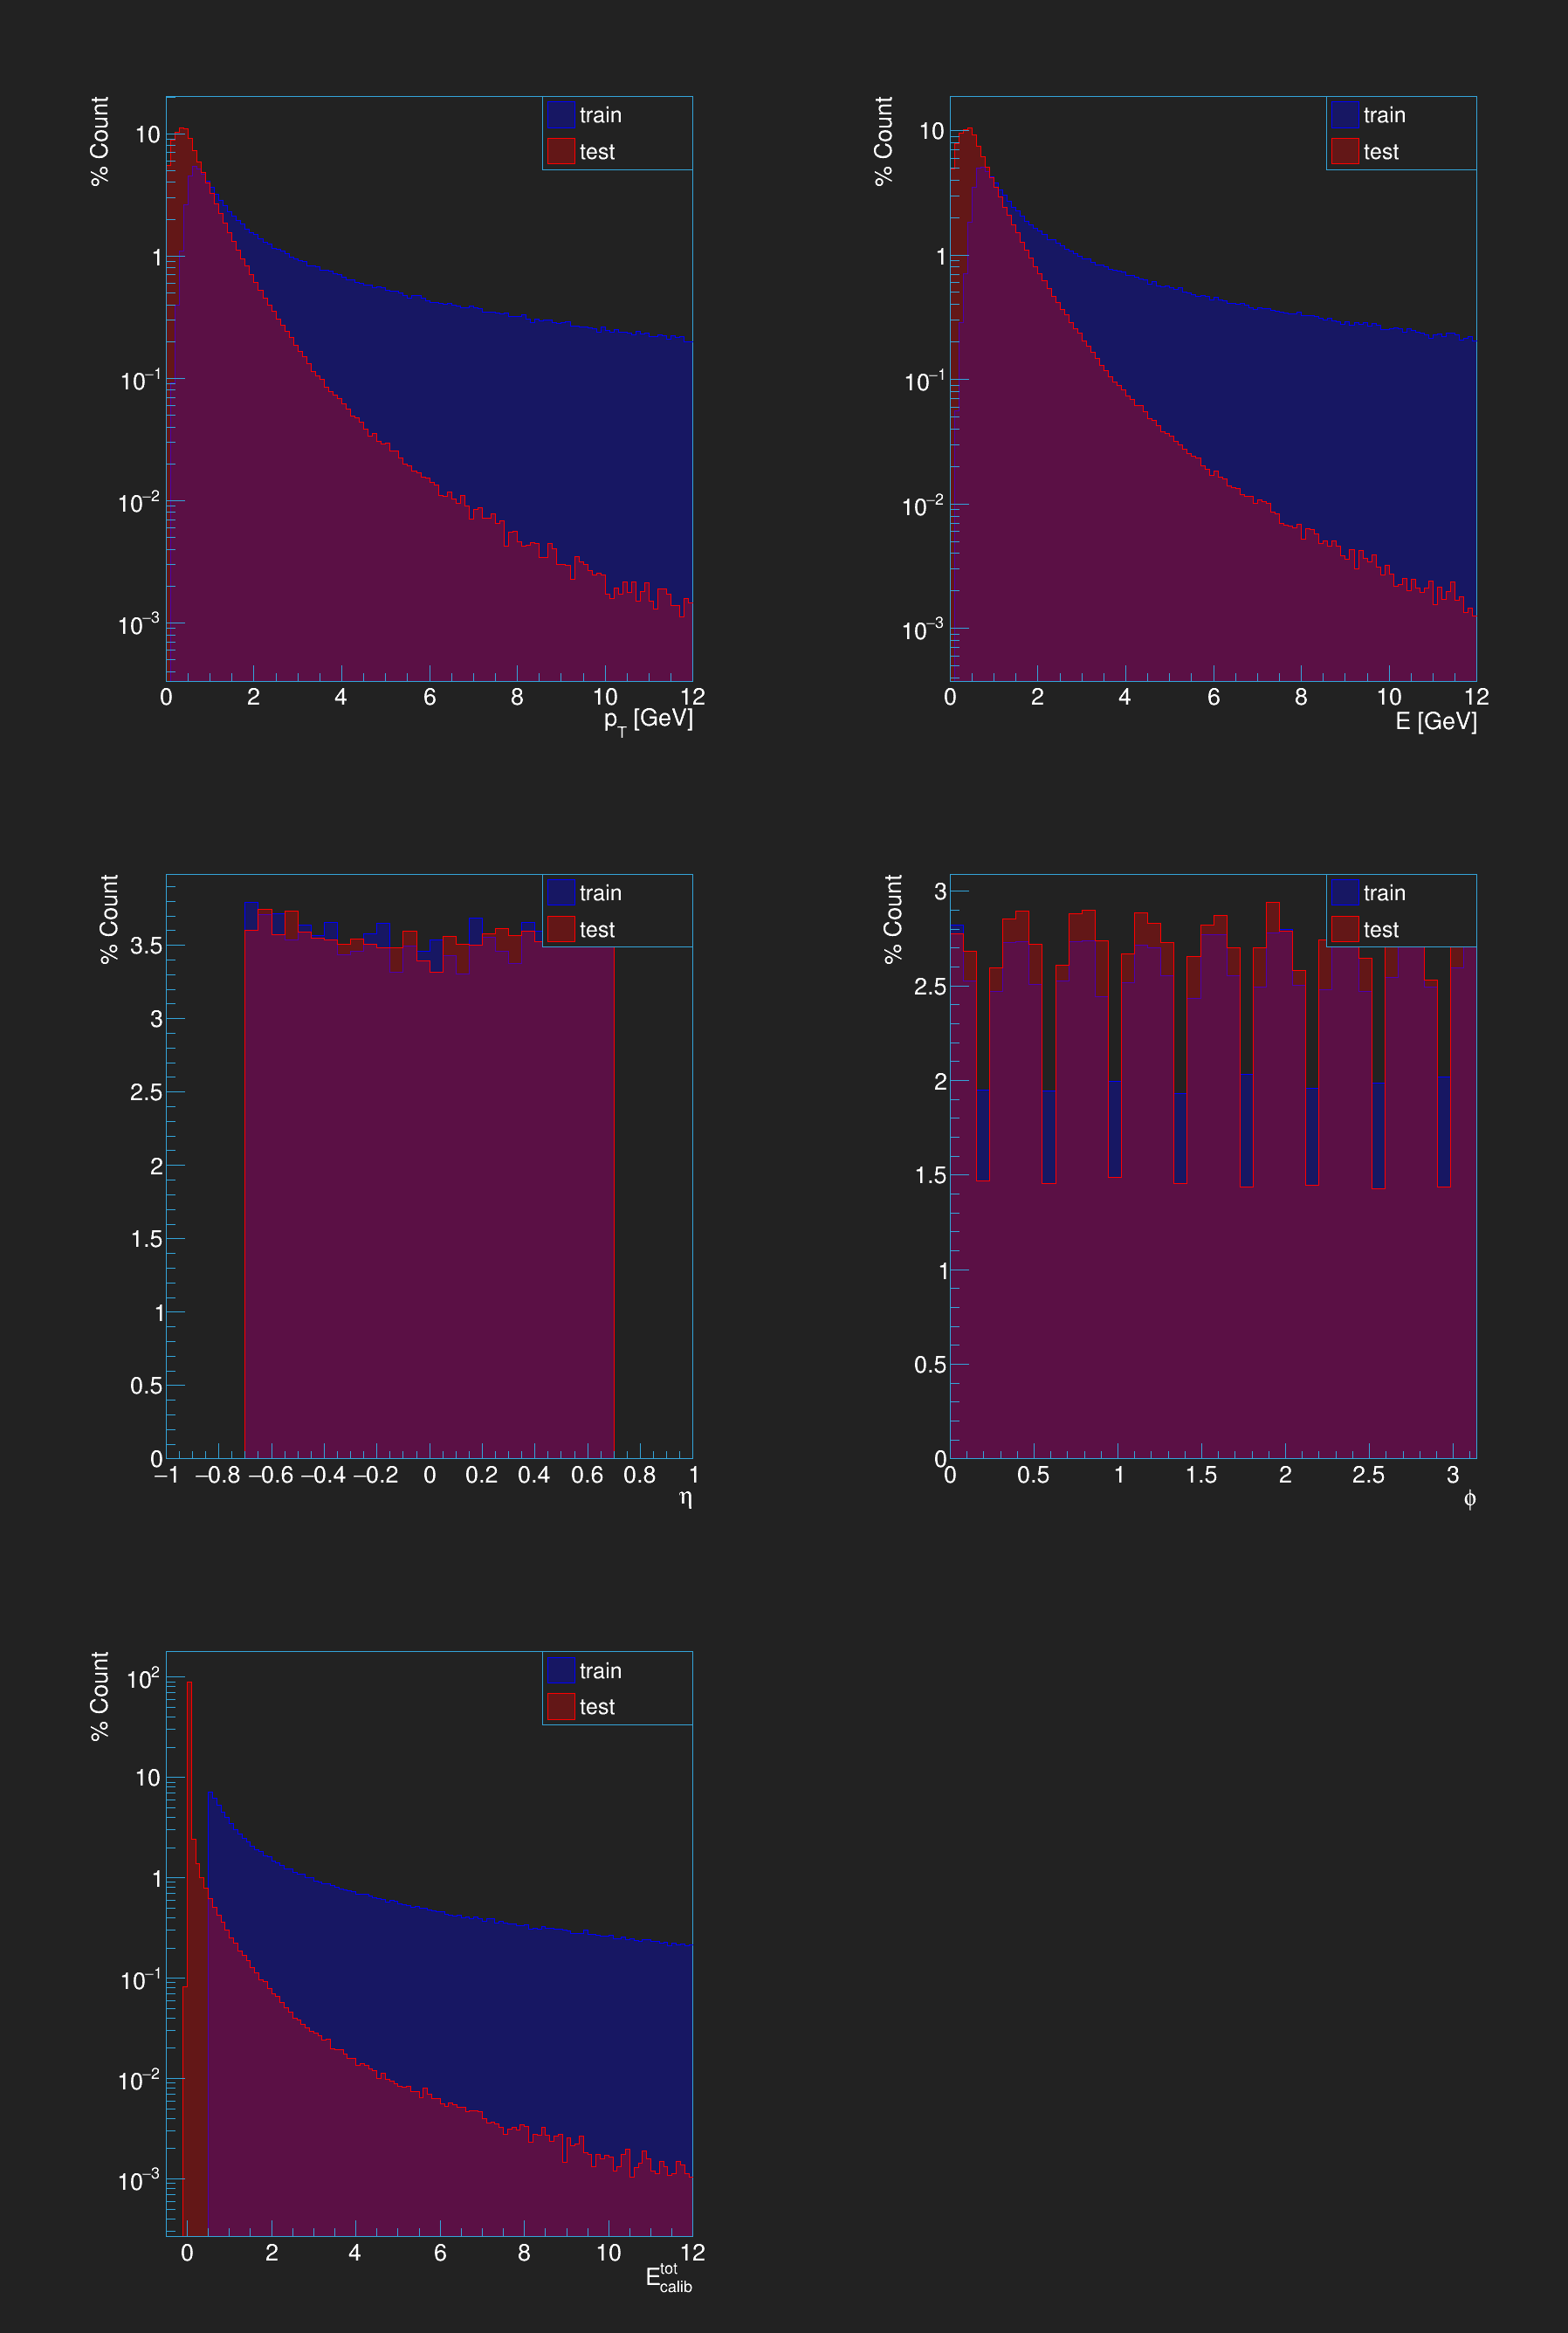

In [28]:
cluster_kinematics = {}

ranges = {
    'pt':(120,0.,12.),
    'e':(120,0.,12.),
    'eta':(40,-1.,1.),
    'phi':(40,0., np.pi),
    'eng_calib_tot':(125,-0.5,12.)
}

titles = {
    'pt':';p_{T} [GeV];% Count',
    'e':';E [GeV];% Count',
    'eta':';#eta;% Count',
    'phi':';#phi;% Count',
    'eng_calib_tot':';E_{calib}^{tot};% Count'
}

branches = {
    'pt':'clusterPt',
    'e':'clusterE',
    'eta':'clusterEta',
    'phi':'clusterPhi',
    'eng_calib_tot':'cluster_ENG_CALIB_TOT'
}

color = {
    'train': rt.kBlue,
    'test': rt.kRed
}

log = {
    'pt':True,
    'e':True,
    'eta':False,
    'phi':False,
    'eng_calib_tot':True
}

assert(set(ranges.keys()) == set(titles.keys()))
assert(set(ranges.keys()) == set(branches.keys()))
keys = list(ranges.keys())
keys2 = list(color.keys())

for key in keys:
    cluster_kinematics[key] = {}
    for key2 in keys2:
        cluster_kinematics[key][key2] = rt.TH1F(str(uuid.uuid4()), key, ranges[key][0], ranges[key][1], ranges[key][2])

        if(key2=='test'):
            for dfile, tree in ur_trees.items():
                for entry in tree['cluster'].array(branches[key]).flatten(): cluster_kinematics[key][key2].Fill(entry)
            
        elif(key2=='train'):
            for dfile, tree in training_trees.items():
                vals = tree.array(branches[key]).flatten()[training_indices[dfile]]
                for entry in vals: cluster_kinematics[key][key2].Fill(entry)
        
        # now normalize each histogram to have an area of 100
        integral = cluster_kinematics[key][key2].Integral()
        #print(key,key2, 1. / integral)
        cluster_kinematics[key][key2].Scale(100. / integral)
        
        # some formatting
        cluster_kinematics[key][key2].SetFillColorAlpha(color[key2],0.3)
        cluster_kinematics[key][key2].SetLineColor(color[key2])
                    
nx = 2
ny = int(np.ceil(len(ranges) / nx))
n = len(keys)

c = rt.TCanvas(str(uuid.uuid4()),'c_cluster_kinematics',1800,900 * ny)
c.Divide(nx,ny)

legend = rt.TLegend(0.7,0.8,0.9,0.9)
legend.AddEntry(cluster_kinematics[keys[0]]['train'],'train','f')
legend.AddEntry(cluster_kinematics[keys[0]]['test'],'test','f')
legend.SetTextColor(plot_style.text)

stacks = []
for i in range(n):
    
    mini_canvas = rt.TCanvas(str(uuid.uuid4()),'mini_canv',500,400)
    canvases = [(c,i+1),(mini_canvas,0)]
    
    stack = rt.THStack(str(uuid.uuid4()),'stack')
    stack.Add(cluster_kinematics[keys[i]]['train'])
    stack.Add(cluster_kinematics[keys[i]]['test'])
    
    for canvas, num in canvases:
        canvas.cd(num)
        
        rt.gPad.SetLeftMargin(0.2)
        stack.SetTitle(titles[keys[i]])
        stack.Draw('NOSTACK HIST')
        legend.Draw()

        if(log[keys[i]]): rt.gPad.SetLogy()
        else: stack.GetHistogram().SetMinimum(0.)
        
        if(num == 0): canvas.SaveAs(plot_dir + '/' + 'cluster_' + keys[i] + '.png')
    stacks.append(stack)

c.Draw()

It appears that there are *significant* differences between these distributions, in both shape and domain (especially in the case of $E_\text{calib}^\text{tot}$). As noted earlier when looking at minimum $\Delta R$, we're considering *all* topo-clusters for the testing data. This may include some that were used to cluster jets that didn't pass cuts.